In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.keras as iso

from aparent.losses.aparent_losses import *

from visualization.seqprop_visualization import *
from generator.seqprop_generator import *
from predictor.seqprop_predictor import *
from predictor.definitions.aparent_large_all_libs import load_saved_predictor
from optimizer.seqprop_optimizer import *


Using TensorFlow backend.


In [2]:

#Define target isoform loss function
def get_isoform_loss(target_isoform_use, isoform_start=80, isoform_end=115, use_start=0, use_end=70, use_target_bits=1.8, cse_start=70, cse_end=76, cse_target_bits=1.8, dse_start=76, dse_end=125, dse_target_bits=1.8, entropy_weight=0.0, punish_dn_cse=0.0, punish_up_c=0.0, punish_up_g=0.0, punish_dn_g=0.0, punish_up_aa=0.0, punish_dn_aa=0.0) :
    
    target_iso = np.zeros((1, 1, 1))
    target_iso[:, :, 0] = target_isoform_use
    
    use_entropy_mse = get_target_entropy_sme(pwm_start=use_start, pwm_end=use_end, target_bits=use_target_bits)
    cse_entropy_mse = get_target_entropy_sme(pwm_start=cse_start, pwm_end=cse_end, target_bits=cse_target_bits)
    dse_entropy_mse = get_target_entropy_sme(pwm_start=dse_start, pwm_end=dse_end, target_bits=dse_target_bits)
    
    punish_dn_cse_func = get_punish_cse(pwm_start=74, pwm_end=120)
    
    punish_up_c_func = get_punish_c(pwm_start=20, pwm_end=70)
    
    punish_up_g_func = get_punish_g(pwm_start=20, pwm_end=70)
    punish_dn_g_func = get_punish_g(pwm_start=76, pwm_end=120)
    
    punish_up_aa_func = get_punish_aa(pwm_start=20, pwm_end=70)
    punish_dn_aa_func = get_punish_aa(pwm_start=76, pwm_end=120)

    def loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, _, cut_pred, _, cut_score_pred = predictor_outputs

        #Aggregate total predicted isoform abundance
        iso_pred = K.expand_dims(K.sum(cut_pred[..., isoform_start:isoform_end], axis=-1), axis=-1)
        
        #Create target cut constant
        iso_true = K.tile(K.constant(target_iso), (K.shape(sampled_pwm)[0], K.shape(sampled_pwm)[1], 1))

        #Specify costs
        #iso_loss = 1.0 * K.mean(symmetric_sigmoid_kl_divergence(iso_true, iso_pred), axis=0)
        iso_loss = 1.0 * K.mean(sigmoid_kl_divergence(iso_true, iso_pred), axis=0)
        
        seq_loss = 0.0
        seq_loss += punish_dn_cse * K.mean(punish_dn_cse_func(sampled_pwm), axis=0)
        seq_loss += punish_up_c * K.mean(punish_up_c_func(sampled_pwm), axis=0)
        seq_loss += punish_up_g * K.mean(punish_up_g_func(sampled_pwm), axis=0)
        seq_loss += punish_dn_g * K.mean(punish_dn_g_func(sampled_pwm), axis=0)
        seq_loss += punish_up_aa * K.mean(punish_up_aa_func(sampled_pwm), axis=0)
        seq_loss += punish_dn_aa * K.mean(punish_dn_aa_func(sampled_pwm), axis=0)
        
        entropy_loss = entropy_weight * (use_entropy_mse(pwm) + cse_entropy_mse(pwm) + dse_entropy_mse(pwm))
        
        #Compute total loss
        total_loss = iso_loss + seq_loss + entropy_loss

        return K.sum(total_loss, axis=0)
    
    return loss_func


#Function for running SeqProp on a set of objectives to optimize
def run_seqprop(sequence_templates, loss_funcs, library_context, n_sequences=1, n_samples=1, n_epochs=10, steps_per_epoch=100) :
    
    n_objectives = len(sequence_templates)
    
    optimized_pwms = []
    optimized_cuts = []
    
    for obj_ix in range(n_objectives) :
        print("Optimizing objective " + str(obj_ix) + '...')
        
        sequence_template = sequence_templates[obj_ix]
        loss_func = loss_funcs[obj_ix]
        
        #Build Generator Network
        _, seqprop_generator = build_generator(seq_length=205, n_sequences=n_sequences, n_samples=n_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=True)
        
        #Build Predictor Network and hook it on the generator PWM output tensor
        _, seqprop_predictor = build_predictor(seqprop_generator, load_saved_predictor(model_path, library_context=library_context), n_sequences=n_sequences, n_samples=n_samples, eval_mode='sample')
        
        #Build Loss Model (In: Generator seed, Out: Loss function)
        _, loss_model = build_loss_model(seqprop_predictor, loss_func)
        
        #Specify Optimizer to use
        #opt = keras.optimizers.SGD(lr=0.1)
        opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

        #Compile Loss Model (Minimize self)
        loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

        #Specify callback entities
        callbacks =[
            EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=0, mode='auto'),
            SeqPropMonitor(predictor=seqprop_predictor, plot_every_epoch=False, track_every_step=True, cse_start_pos=70, isoform_start=80, isoform_end=115, pwm_start=70-40, pwm_end=76+50, sequence_template=sequence_template, plot_pwm_indices=[0])
        ]

        #Fit Loss Model
        train_history = loss_model.fit(
            [], np.ones((1, 1)), #Dummy training example
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=callbacks
        )
        
        #Retrieve optimized PWMs and predicted cleavage distributionns
        _, optimized_pwm, _, _, cut_pred, _, _ = seqprop_predictor.predict(x=None, steps=1)
        
        optimized_pwms.append(optimized_pwm)
        optimized_cuts.append(cut_pred)

    return optimized_pwms, optimized_cuts



In [3]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../aparent/saved_models')
model_name = 'aparent_large_all_libs.h5'
model_path = os.path.join(save_dir, model_name)

Running optimization experiment 'Alien1 Isoforms'
Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 235s 118ms/step - loss: 0.2435


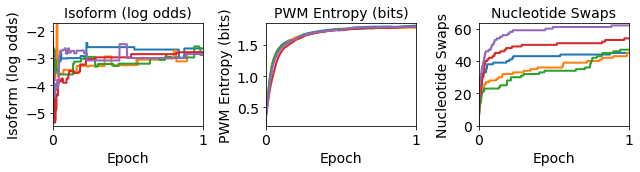

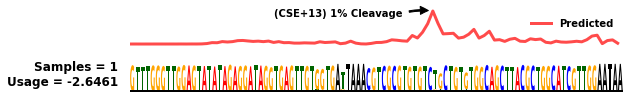

Optimizing objective 1...
Epoch 1/1
2000/2000 [==============================] - 215s 108ms/step - loss: 0.4951


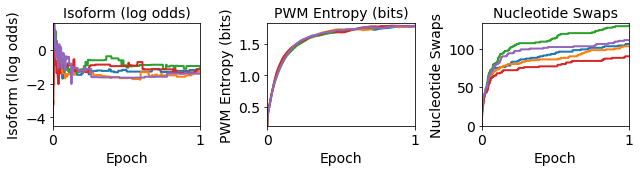

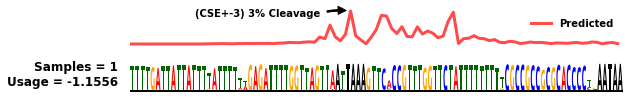

Optimizing objective 2...
Epoch 1/1
2000/2000 [==============================] - 130s 65ms/step - loss: 0.6337


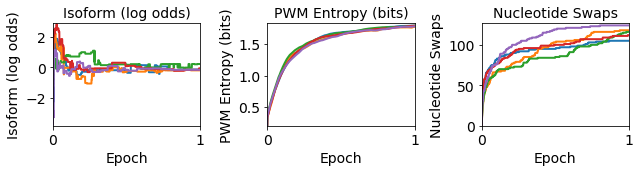

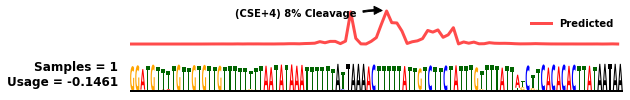

Optimizing objective 3...
Epoch 1/1
2000/2000 [==============================] - 133s 67ms/step - loss: 0.6249


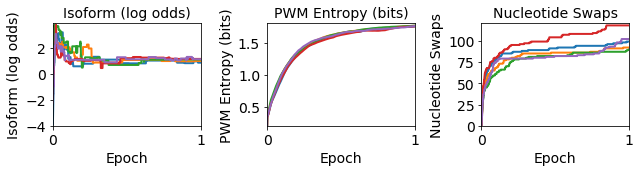

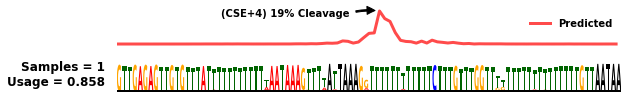

Optimizing objective 4...
Epoch 1/1
2000/2000 [==============================] - 160s 80ms/step - loss: 0.6827


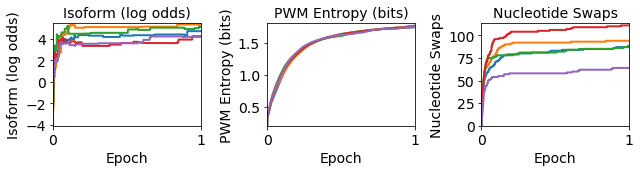

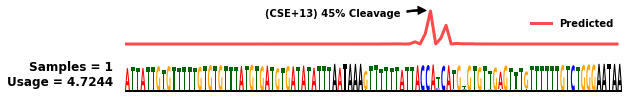

In [5]:
#Optimize target isoform proportions for the 'Alien1' (aka 'Simple') library

seq_template = 'XXXXXXXXXXXXXXXXXXXXXATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNANTAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAAGTCCTGCCCGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG'
library_context = 'simple'

iso_objectives = [0.05, 0.25, 0.50, 0.75, 1.0]

#Run SeqProp Optimization

print("Running optimization experiment 'Alien1 Isoforms'")

#Number of PWMs to generate per objective
n_sequences = 5
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 5
#Number of epochs per objective to optimize
n_epochs = 1#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 2000

sequence_templates = [
    seq_template
    for target_iso in iso_objectives
]

losses = [
    get_isoform_loss(
        target_iso,
        use_start=25,
        use_end=70,
        use_target_bits=1.8,
        cse_start=70,
        cse_end=76,
        cse_target_bits=1.9,
        dse_start=76,
        dse_end=121,
        dse_target_bits=1.8,
        entropy_weight=0.1,
        punish_dn_cse=0.1,
        punish_up_c=0.005,
        punish_up_g=0.0001,
        punish_dn_g=0.00005,
        punish_up_aa=0.0025,
        punish_dn_aa=0.005,
    )
    for target_iso in iso_objectives
]

alien1_pwms, alien1_cuts = run_seqprop(sequence_templates, losses, library_context, n_sequences, n_samples, n_epochs, steps_per_epoch)



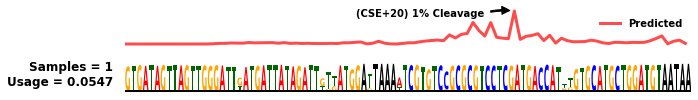

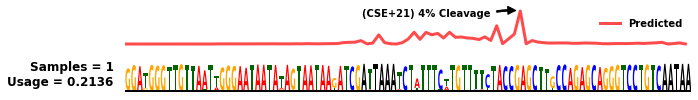

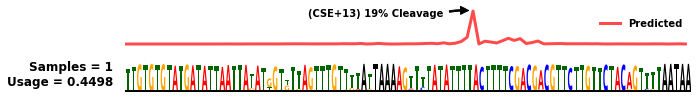

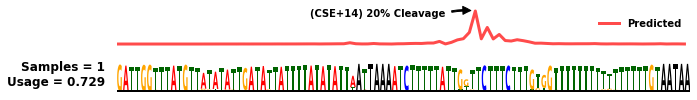

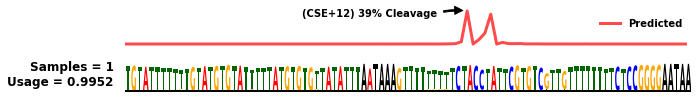

In [6]:
#Plot one PWM sequence logo per optimized objective (Experiment 'Alien2 Isoforms')

pwms = alien1_pwms
cuts = alien1_cuts

pwm_index = 1 #Chosen PWM index
for obj_index, sequence_template in enumerate(sequence_templates) :
    
    pwm = np.expand_dims(pwms[obj_index][pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cuts[obj_index][0, pwm_index, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, 80:115], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=70-40, plot_end=76+50)


Running optimization experiment 'Alien2 Isoforms'
Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 144s 72ms/step - loss: 0.8675


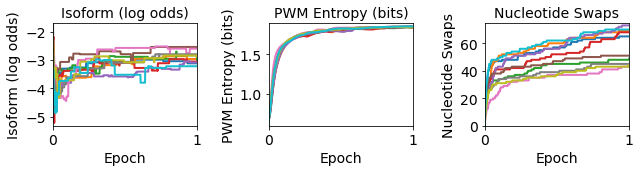

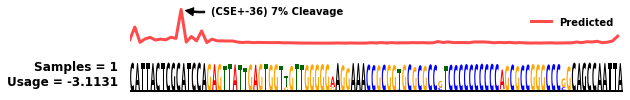

Optimizing objective 1...
Epoch 1/1
2000/2000 [==============================] - 153s 76ms/step - loss: 1.5587


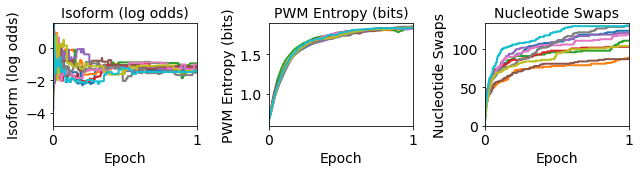

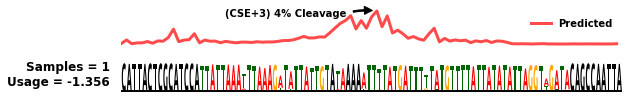

Optimizing objective 2...
Epoch 1/1
2000/2000 [==============================] - 162s 81ms/step - loss: 1.7364


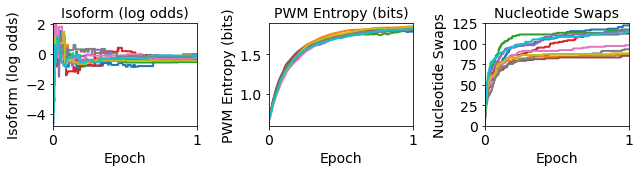

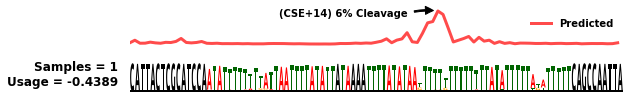

Optimizing objective 3...
Epoch 1/1
2000/2000 [==============================] - 161s 81ms/step - loss: 1.9356


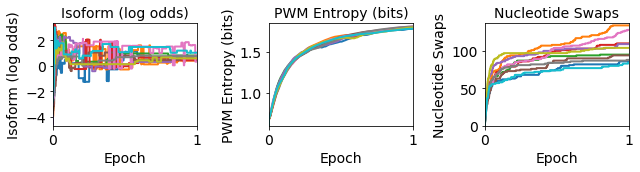

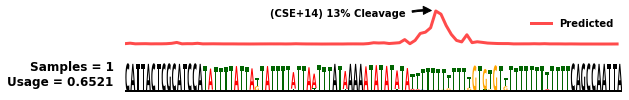

Optimizing objective 4...
Epoch 1/1
2000/2000 [==============================] - 85s 42ms/step - loss: 2.0692


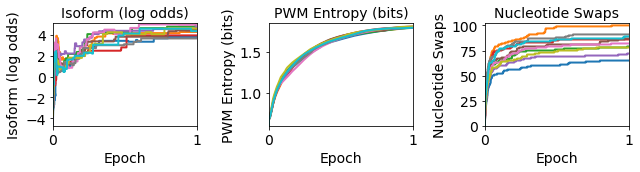

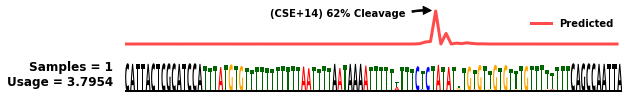

In [7]:
#Optimize target isoform proportions for the 'Alien2' (aka 'Doubledope') library

seq_template = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXCATTACTCGCATCCANNNNNNNNNNNNNNNNNNNNNNNNNANNAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCCAATTAAGCCTGTCGTCGTGGGTGTCGAAAATGAAATAAAACAAGTCAATTGCGTAGTTTATTCAGACGTACCCCGTGGACCTAC'
library_context = 'doubledope'

iso_objectives = [0.05, 0.25, 0.50, 0.75, 1.0]

#Run SeqProp Optimization

print("Running optimization experiment 'Alien2 Isoforms'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 2000

sequence_templates = [
    seq_template
    for target_iso in iso_objectives
]

losses = [
    get_isoform_loss(
        target_iso,
        use_start=45,
        use_end=70,
        use_target_bits=1.8,
        cse_start=70,
        cse_end=76,
        cse_target_bits=1.9,
        dse_start=76,
        dse_end=116,
        dse_target_bits=1.8,
        entropy_weight=0.1,
        punish_dn_cse=0.1,
        punish_up_c=0.005,
        punish_up_g=0.0001,
        punish_dn_g=0.00005,
        punish_up_aa=0.0025,
        punish_dn_aa=0.005,
    )
    for target_iso in iso_objectives
]

alien2_pwms, alien2_cuts = run_seqprop(sequence_templates, losses, library_context, n_sequences, n_samples, n_epochs, steps_per_epoch)



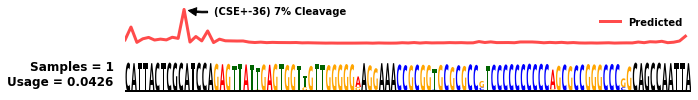

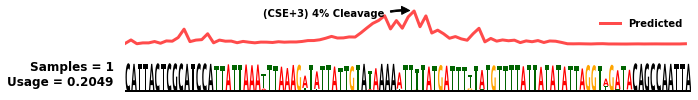

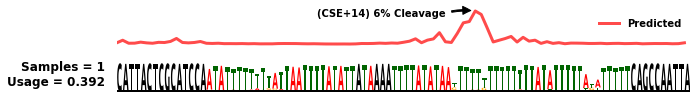

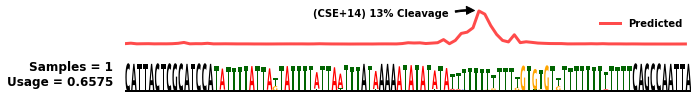

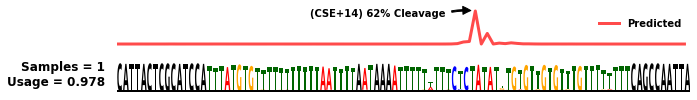

In [8]:
#Plot one PWM sequence logo per optimized objective (Experiment 'Alien2 Isoforms')

pwms = alien2_pwms
cuts = alien2_cuts

pwm_index = 0 #Chosen PWM index
for obj_index, sequence_template in enumerate(sequence_templates) :
    
    pwm = np.expand_dims(pwms[obj_index][pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cuts[obj_index][0, pwm_index, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, 80:115], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=70-40, plot_end=76+50)


Running optimization experiment 'TOMM5 Isoforms'
Optimizing objective 0...


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Epoch 1/1
2000/2000 [==============================] - 60s 30ms/step - loss: 0.7151


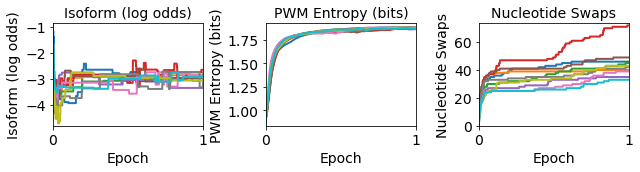

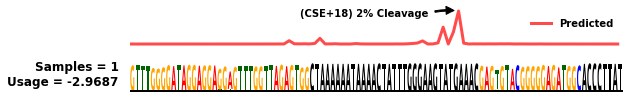

Optimizing objective 1...
Epoch 1/1
2000/2000 [==============================] - 58s 29ms/step - loss: 1.0955


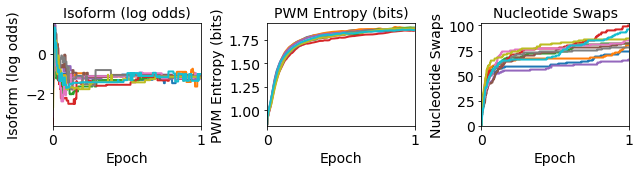

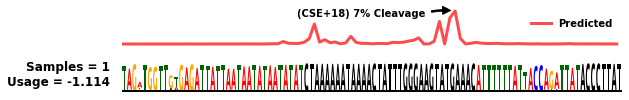

Optimizing objective 2...
Epoch 1/1
2000/2000 [==============================] - 63s 32ms/step - loss: 1.0527


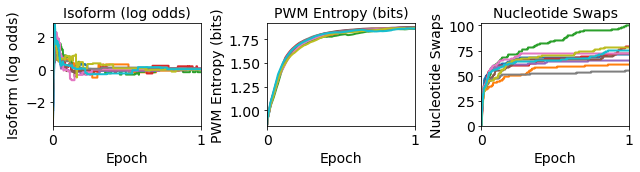

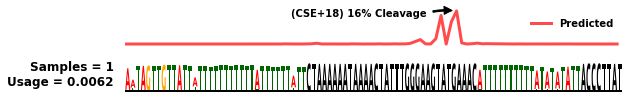

Optimizing objective 3...
Epoch 1/1
2000/2000 [==============================] - 65s 32ms/step - loss: 0.9586


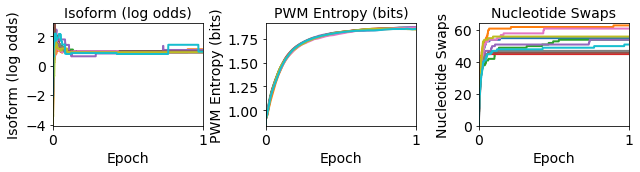

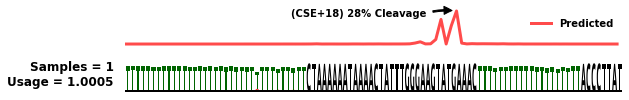

Optimizing objective 4...
Epoch 1/1
2000/2000 [==============================] - 69s 34ms/step - loss: 1.6310


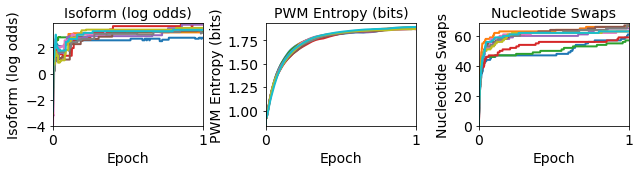

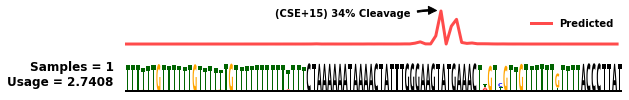

In [4]:
#Optimize target isoform proportions for the 'TOMM5' library

seq_template = 'XXXXXXXXXXXXXXXXXXXXXTGCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCTAAAAAATAAAACTATTTGGGAAGTATGAAACNNNNNNNNNNNNNNNNNNNNACCCTTATCCCTGTGACGTTTGGCCTCTGACAATACTGGTATAATTGTAAATAATGTCAAACTCCGTTTTCTAGCAAGTATTAAGGG'
library_context = 'tomm5_up_c20n20_dn_n20'

iso_objectives = [0.05, 0.25, 0.50, 0.75, 1.0]

#Run SeqProp Optimization

print("Running optimization experiment 'TOMM5 Isoforms'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 2000

sequence_templates = [
    seq_template
    for target_iso in iso_objectives
]

losses = [
    get_isoform_loss(
        target_iso,
        use_start=25,
        use_end=65,
        use_target_bits=1.8,
        cse_start=70,
        cse_end=76,
        cse_target_bits=1.9,
        dse_start=98,
        dse_end=118,
        dse_target_bits=1.8,
        entropy_weight=0.1,
        punish_dn_cse=0.1,
        punish_up_c=0.005,
        punish_up_g=0.0001,
        punish_dn_g=0.00005,
        punish_up_aa=0.0025,
        punish_dn_aa=0.005,
    )
    for target_iso in iso_objectives
]

tomm5_pwms, tomm5_cuts = run_seqprop(sequence_templates, losses, library_context, n_sequences, n_samples, n_epochs, steps_per_epoch)



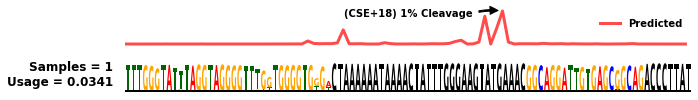

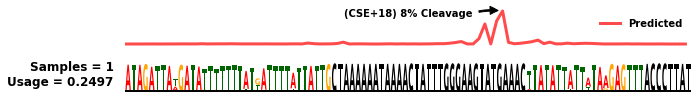

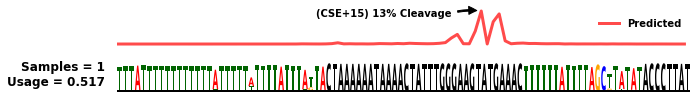

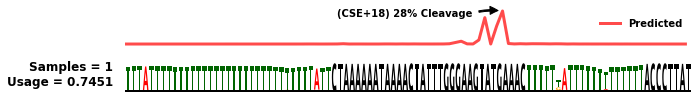

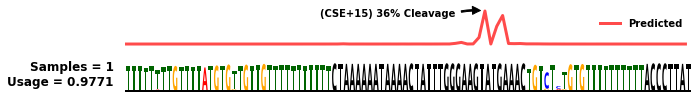

In [12]:
#Plot one PWM sequence logo per optimized objective (Experiment 'TOMM5 Isoforms')

pwms = tomm5_pwms
cuts = tomm5_cuts

pwm_index = 4 #Chosen PWM index
for obj_index, sequence_template in enumerate(sequence_templates) :
    
    pwm = np.expand_dims(pwms[obj_index][pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cuts[obj_index][0, pwm_index, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, 80:115], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=70-40, plot_end=76+50)


Running optimization experiment 'Max Isoforms of All libraries'
Optimizing objective 0...
Epoch 1/1
3000/3000 [==============================] - 252s 84ms/step - loss: 0.5739


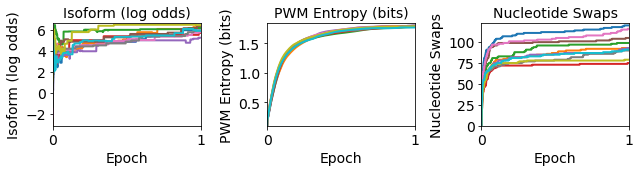

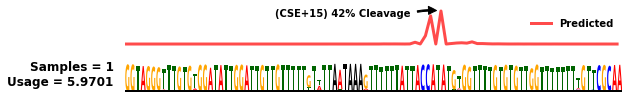

Optimizing objective 0...
Epoch 1/1
3000/3000 [==============================] - 253s 84ms/step - loss: 1.2496


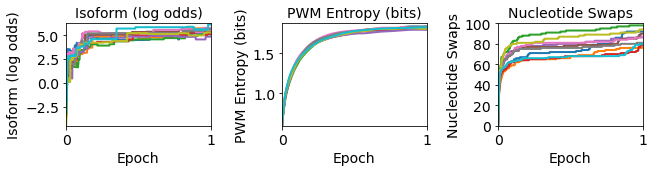

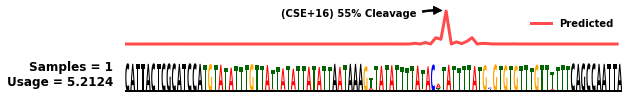

Optimizing objective 0...
Epoch 1/1
3000/3000 [==============================] - 265s 88ms/step - loss: 1.1866


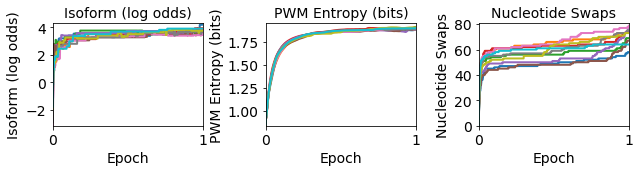

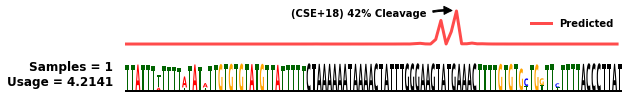

Optimizing objective 0...
Epoch 1/1
3000/3000 [==============================] - 255s 85ms/step - loss: 0.8632


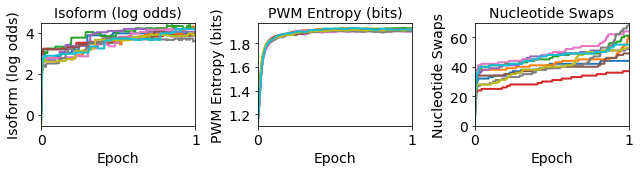

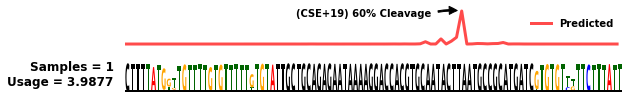

Optimizing objective 0...
Epoch 1/1
3000/3000 [==============================] - 253s 84ms/step - loss: 1.6933


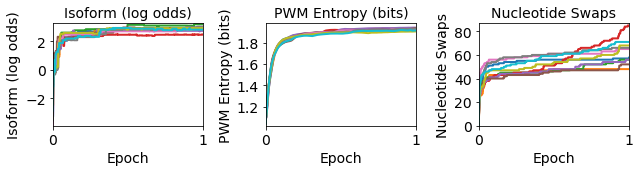

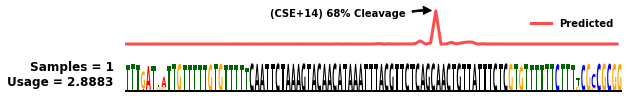

Optimizing objective 0...
Epoch 1/1
3000/3000 [==============================] - 255s 85ms/step - loss: 0.9083


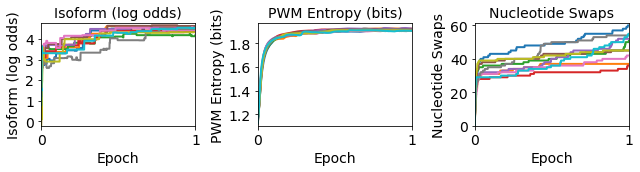

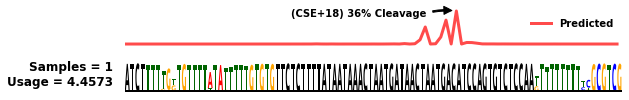

Optimizing objective 0...
Epoch 1/1
3000/3000 [==============================] - 256s 85ms/step - loss: 0.7972


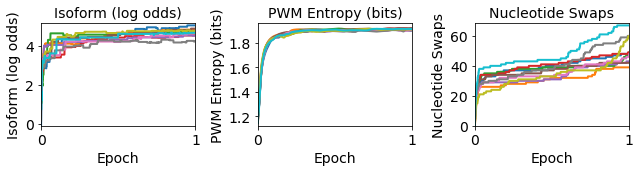

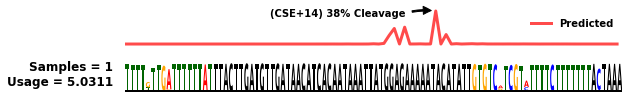

Optimizing objective 0...
Epoch 1/1
3000/3000 [==============================] - 259s 86ms/step - loss: 1.9631


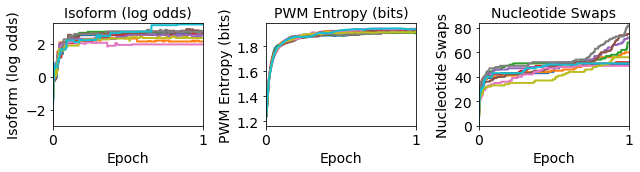

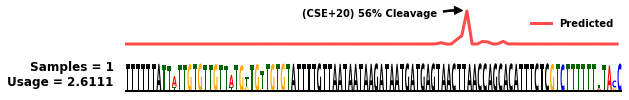

Optimizing objective 0...
Epoch 1/1
3000/3000 [==============================] - 259s 86ms/step - loss: 0.7332


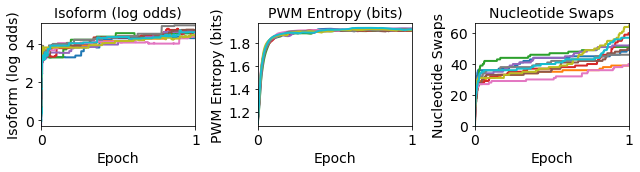

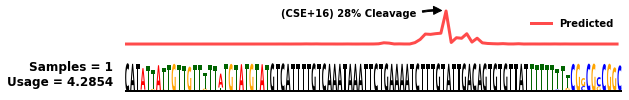

In [6]:
#Maximize isoform proportions for all native minigene libraries

seq_templates = [
    'XXXXXXXXXXXXXXXXXXXXXATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNANTAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGTCCTGCCCGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG',
    'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXCATTACTCGCATCCANNNNNNNNNNNNNNNNNNNNNNNNNANNAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCCAATTAAGCCTGTCGTCGTGGGTGTCGAAAATGAAATAAAACAAGTCAATTGCGTAGTTTATTCAGACGTACCCCGTGGACCTAC',
    'XXXXXXXXXXXXXXXXXXXXXTGCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCTAAAAAATAAAACTATTTGGGAAGTATGAAACNNNNNNNNNNNNNNNNNNNNACCCTTATCCCTGTGACGTTTGGCCTCTGACAATACTGGTATAATTGTAAATAATGTCAAACTCCGTTTTCTAGCAAGTATTAAGGG',
    'XXXXXXXXXXXXXXXXXXXXXATCTCTGAGCTTTNNNNNNNNNNNNNNNNNNNNNNNNNTTGCTGCAGAGAATAAAAGGACCACGTGCAATACTTAATGCCGCATGATCNNNNNNNNNNNNNNNNNNNNNNNNNGGCTCTTTTGACAGCCTTTGGCGTCTGTAGAATAAATGCTGTGGCTCCTGCTGGCTGCTGTGGTGTTCACC',
    'XXXXXXXXXXXXXXXXXXXXXTGCATTTGNNNNNNNNNNNNNNNNNNNNNNNNNCAATTCTAAAGTACAACATAAATTTACGTTCTCAGCAACTGTTATTTCTCNNNNNNNNNNNNNNNNNNNNNNNNNAATATACATTCAGTTATTAAGAAATAAACTGCTTTCTTAATACATACTGTGCATTATAATTGGAGAAATAGAATAT',
    'XXXXXXXXXXXXXXXXXXXXXTCTTCTGAAATCTNNNNNNNNNNNNNNNNNNNNNNNNNTTCTCTTTTATAATAAACTAATGATAACTAATGACATCCAGTGTCTCCAANNNNNNNNNNNNNNNNNNNNNNNNNCACTTCCAAATAAAAATATGTAAATGAGTGGTTAATCTTTAGTTATTTTAAGATGATTTTAGGGTTTTGCT',
    'XXXXXXXXXXXXXXXXXXXXXANNNNNNNNNNNNNNNNNNNNNNNNNTTACTTGATGTTGATAACATCACAATAAATTATGGAGAAAAATACATATTNNNNNNNNNNNNNNNNNNNNNNNANTAAAGTGTTTTCTTTTAAATCAACTCTAAATAGCTCCATTCTCATAGTCACTAGTCAGACCGCTCGCGCACTACTCAGCGACC',
    'XXXXXXXXXXXXXXXXXXXXXCGATCTTCTTTTTTTANNNNNNNNNNNNNNNNNNNNNNNNNATTTTGTTAATAATAAGATAATGATGAGTAACTTAACCAGCACATTTCTCNNNNNNNNNNNNNNNNNNNNNNNNNGTTTTCTGATGACATAATAAAGACAGATCATTTCAGAATCTGGCCCTTGTGCAGGGGAGGAGGGAGGC',
    'XXXXXXXXXXXXXXXXXXXXXCTTGAATTTCATNNNNNNNNNNNNNNNNNNNNNNNNNGTCATTTTGTCAAATAAATTCTGAAAATCTTTGTATTGACAGTGTGTTATNNNNNNNNNNNNNNNNNNNNNNNNNAGTGCTCAATAAAAAGAATAAAGAGGAAACAGCACTGGATCTATACCTATACAAAACAAGCTACCAGCGCTC'
]

region_start_ends = [
    [[4, 49], [49, 55], [55, 100]],
    [[24, 49], [49, 55], [55, 101]],
    [[4, 44], [49, 55], [77, 97]],
    [[13, 13 + 25], [49, 55], [13 + 75, 13 + 100]],
    [[8, 8 + 25], [49, 55], [8 + 75, 8 + 100]],
    [[13, 13 + 25], [49, 55], [13 + 75, 13 + 100]],
    [[1, 1 + 25], [49, 55], [1 + 75, 1 + 100]],
    [[16, 16 + 25], [49, 55], [16 + 75, 16 + 100]],
    [[12, 12 + 25], [49, 55], [12 + 75, 12 + 100]]
]

library_contexts = [
    'simple',
    'doubledope',
    'tomm5_up_c20n20_dn_n20',
    'aar',
    'atr',
    'hsp',
    'snh',
    'sox',
    'wha'
]

iso_objectives = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Run SeqProp Optimization

print("Running optimization experiment 'Max Isoforms of All libraries'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 5
#Number of epochs per objective to optimize
n_epochs = 1#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 3000

sequence_templates = [
    seq_template
    for target_iso in iso_objectives
]

losses = [
    get_isoform_loss(
        target_iso,
        use_start=region[0][0] + 21,
        use_end=region[0][1] + 21,
        use_target_bits=1.8,
        cse_start=region[1][0] + 21,
        cse_end=region[1][1] + 21,
        cse_target_bits=1.9,
        dse_start=region[2][0] + 21,
        dse_end=region[2][1] + 21,
        dse_target_bits=1.8,
        entropy_weight=0.1,
        punish_up_c=0.005,
        punish_up_g=0.0001,
        punish_dn_g=0.00005,
        punish_up_aa=0.0025,
        punish_dn_aa=0.005,
    )
    for target_iso, region in zip(iso_objectives, region_start_ends)
]

max_pwms = []
max_cuts = []

for seq_template, library_context, loss in zip(seq_templates, library_contexts, losses) :

    pwm, cut = run_seqprop([seq_template], [loss], library_context, n_sequences, n_samples, n_epochs, steps_per_epoch)

    max_pwms.extend(pwm)
    max_cuts.extend(cut)


Library = simple


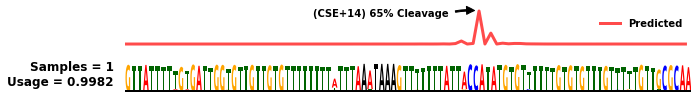

Library = doubledope


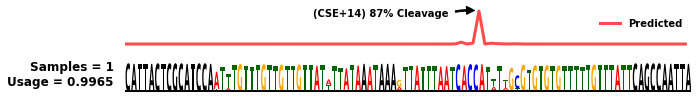

Library = tomm5_up_c20n20_dn_n20


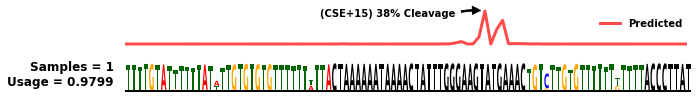

Library = aar


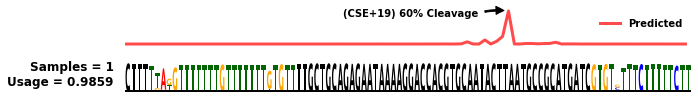

Library = atr


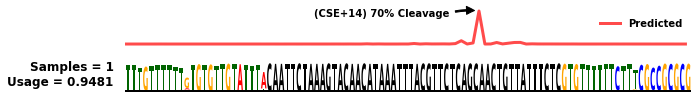

Library = hsp


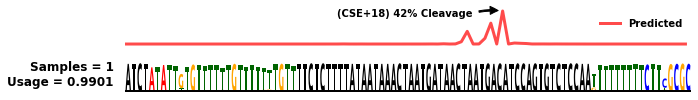

Library = snh


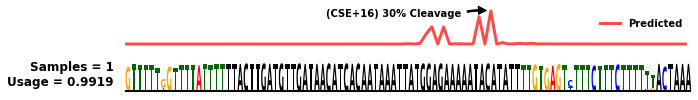

Library = sox


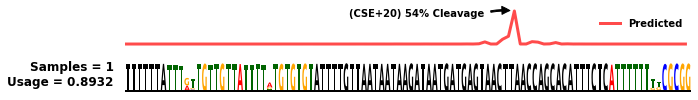

Library = wha


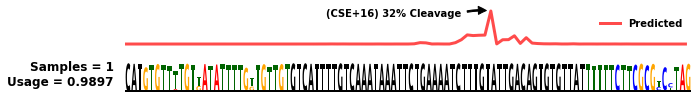

In [7]:
#Plot one PWM sequence logo per optimized objective (Experiment 'Max Isoforms of 6 libraries')

pwms = max_pwms
cuts = max_cuts

pwm_index = 1 #Chosen PWM index
for obj_index, library_context in enumerate(library_contexts) :
    
    print("Library = " + str(library_context))
    
    pwm = np.expand_dims(pwms[obj_index][pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cuts[obj_index][0, pwm_index, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, 80:115], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=seq_templates[obj_index], figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=70-40, plot_end=76+50)
